# Exploring ["The Well" Active matter simulations](https://polymathic-ai.org/the_well/datasets/active_matter/#active-matter-simulations) dataset

This notebook explores the dataset and roughly follows the [dataset tutorial](https://polymathic-ai.org/the_well/tutorials/dataset/) found on The Well's documentation, but looks specifically at the active matter simulations dataset, with clarifying notes. This is a prelude to using the dataset as an example for The Alan Turing Institute's [AutoEmulate](https://github.com/alan-turing-institute/autoemulate) project.


In [6]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from torch.utils.data import DataLoader
from einops import rearrange
from tqdm import tqdm
import os

# from neuralop.models import FNO

from the_well.benchmark.metrics import VRMSE
from the_well.data import WellDataset
from the_well.utils.download import well_download


Notebook TODOs:
- [x] Try different colour maps to visualise the data
- [ ] Train FNO model from example
- [ ] Download the validation set
- [ ] Carry out evaluation of the model

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Download the dataset or stream from Hugging Face Hub

In [7]:
# Download the training dataset
base_path = "./datasets/datasets"  # path/to/storage
# This took over 80 min to download
if os.path.exists(os.path.join(base_path, "active_matter")):
    print(f"Dataset already downloaded.")
else:
    well_download(base_path=base_path, dataset="active_matter", split="train")

Dataset already downloaded.


In [ ]:
# Set the base path to huggingface hub if you want to stream instead of downloading
# base_path = "hf://datasets/polymathic-ai/"

In [8]:
# Create the dataset
trainset = WellDataset(
    well_base_path=base_path,  # access from HF hub
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=81,  # 81 time steps in the active matter dataset
    n_steps_output=0,
)

On the web page for the dataset, the parameters are described as:

Set of coefficients or non-dimensional parameters evaluated:

```
    α= {-1,-2,-3,-4,-5}

    β= {0.8}

    ζ= {1,3,5,7,9,11,13,15,17}
```

This means the total number of parameter combinations is 5 x 1 x 9 = 45.

There are 5 trajectories (simulations) for each parameter combination, so the total number of trajectories is 5 x 45 = 225.

In [9]:
# The length of of the training dataset should be < 225
len(trainset)

175

In [32]:
# Look at the available fields
field_names = [
    name for group in trainset.metadata.field_names.values() for name in group
]
field_names

['concentration',
 'velocity_x',
 'velocity_y',
 'D_xx',
 'D_xy',
 'D_yx',
 'D_yy',
 'E_xx',
 'E_xy',
 'E_yx',
 'E_yy']

In [11]:
# If we have set the n_steps_input to 81, the shape of the input fields should be (81, 256, 256, 11)
# So we have 81 time steps and for each of 11 fields a 256 x 256 grid which could be viewed as a 2D image
trainset[174]['input_fields'].shape

torch.Size([81, 256, 256, 11])

The most important elements are `input_fields` and `output_fields`.

They represent the time-varying physical fields of the dynamical system and are generally the input and target of our models.

In [12]:
# As well as the input_fields, we have:    (note: will only include output_fields if n_steps_output > 0)
trainset[174].keys()

dict_keys(['input_fields', 'constant_scalars', 'boundary_conditions', 'space_grid', 'input_time_grid'])

## Visualise the data

We know from calling `trainset.metadata.field_names` that field 0 out of 11 is concentration.

In [26]:
# Create a function to animate simulation images

def animate_simulation(simulation):
    """
    Function to animate a 3D simulation using matplotlib.
    Args:
        simulation (numpy.ndarray): A 3D numpy array of shape (num_frames, height, width).
                                    The first dimension represents the time steps.
    """

    # Create a figure and axis for the animation
    fig, ax = plt.subplots(figsize=(6, 6))

    # Add the first frame
    img = ax.imshow(simulation[0], cmap='RdBu_r', origin="upper")
    ax.axis("off")

    # Function to update the frame
    def update(frame):
        img.set_data(simulation[frame])
        ax.set_title(f"Frame {frame + 1}")
        return img,

    # Create the animation
    num_frames = simulation.shape[0]
    ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=200)

    # Convert animation to HTML
    html_anim = HTML(ani.to_jshtml())
    plt.close(fig)  # Prevents static image display
    return html_anim

In [41]:
# Choose a random index to get a simulation/trajectory to visualise
simulation_4d = trainset[40]
# Create a 3D array for the simulation run to pass to the visualisation
conc_index = field_names.index("concentration")
simulation = simulation_4d["input_fields"][:, :, :, conc_index].numpy()
# Animate the simulation
animate_simulation(simulation)

Now let's take a look at all the fields in the dataset, not just concentration:

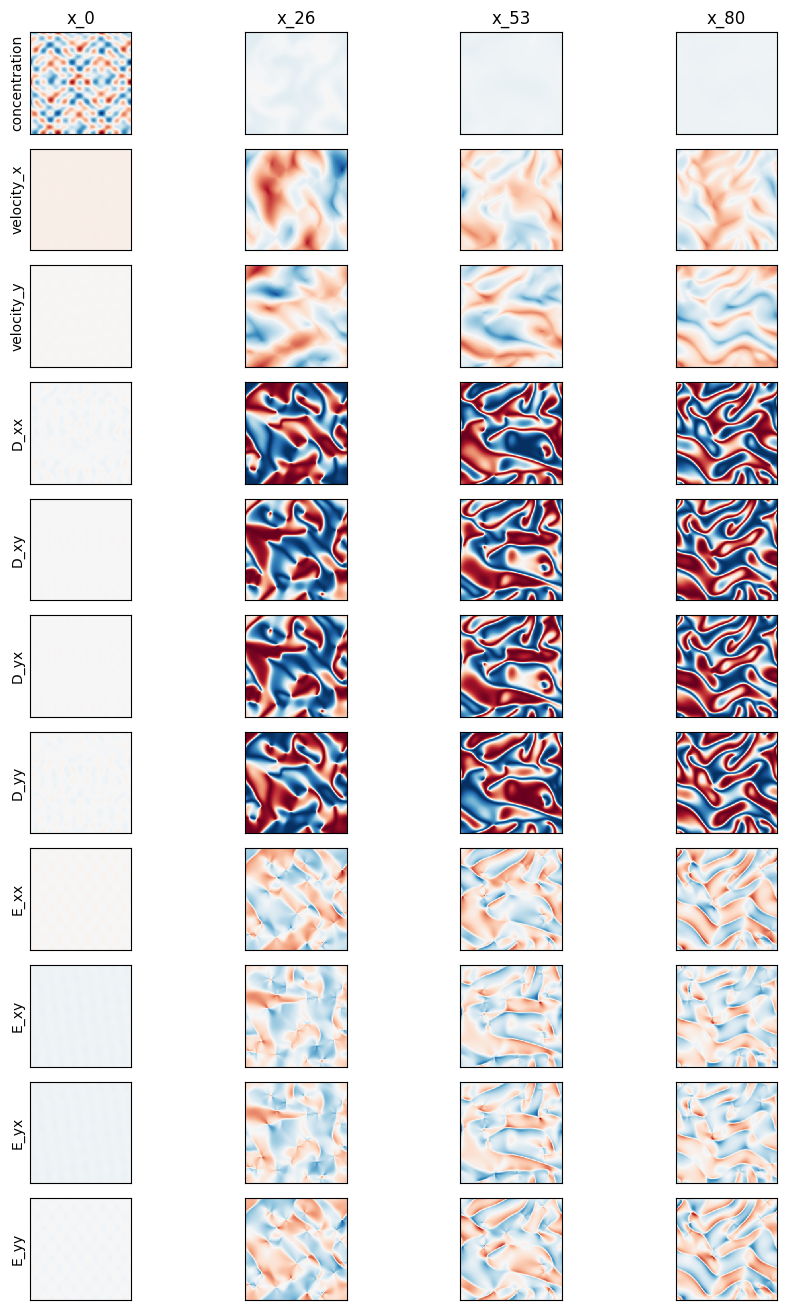

In [59]:
# Get the simulation we chose in the previous cell and rearrange it to be (Field, Timestep, Lx, Ly)
x = rearrange(simulation_4d["input_fields"], "Timestep Lx Ly Field -> Field Timestep Lx Ly")

# Get a list of 4 evenly spaced timesteps to visualise
n_timesteps = len(simulation_4d["input_fields"])
timesteps = np.linspace(0, n_timesteps - 1, 4).astype(int)

# Create a figure to show every field for 4 timesteps of the simulation
F = trainset.metadata.n_fields
fig, axs = plt.subplots(F, 4, figsize=(4 * 2.4, F * 1.2))

for field in range(F):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    axs[field, 0].set_ylabel(f"{field_names[field]}")

    for t in range(4):
        ts = timesteps[t]
        axs[field, t].imshow(
            x[field, ts], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax
        )
        axs[field, t].set_xticks([])
        axs[field, t].set_yticks([])

        axs[0, t].set_title(f"x_{ts}")

plt.tight_layout()